In [18]:
import pandas as pd
import numpy as np

data = pd.read_csv('IFR_Extract_with_selected_columns_15-5-23.csv')

obreak_date = pd.to_datetime(data.obreak_date)
datebone = pd.to_datetime(data.datebone)
y = ( abs( datebone - obreak_date))
X = pd.DataFrame({
    "PatientAge": data.PatientAge,
    "PatientGender": data.PatientGender,
    
})
y

0       524 days
1      2046 days
2     15455 days
3      4354 days
4      2207 days
         ...    
795     579 days
796    5109 days
797    2125 days
798     518 days
799     483 days
Length: 800, dtype: timedelta64[ns]

In [19]:

# X = data.drop(['PostalCode','DateSurveyed','obreak_date','datebone','obone_text','rxother_text'
# ,'rx2_other_text','norxo_text','obone_text','obreak_obone_text'],axis=1)

dropList = []
for i in data:
    if data[i].dtypes == 'O':
        dropList.append(data[i].name)
dropList.append("CompletedSurveyId")
dropList.append("PatientId")
X = data.drop(dropList,axis=1)
X.fillna(0,inplace=True)
y = pd.DataFrame({"time":y})


In [20]:
y.time

y['event'] = y.time.apply(lambda x: x.days != 0 )
structured_array = y.to_records(index=False)

swapped = pd.DataFrame({
    "event": y.event,
    "time": y.time.apply(lambda x: x.days)
})
(swapped.time < 100).value_counts()

False    751
True      49
Name: time, dtype: int64

In [21]:
swapped.event = swapped.event.astype(bool)
swapped.event
structured_array = np.rec.array(swapped.to_records(index=False))


In [22]:
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index

X_train, X_test, y_train, y_test = train_test_split(X, structured_array, test_size=0.2, random_state=42)

# Create an instance of the RandomSurvivalForest model
model = RandomSurvivalForest()

# Fit the model on the training data
model.fit(X_train, y_train)

# Calculate the baseline performance
baseline_score = concordance_index(y_test['time'], -model.predict(X_test), y_test['event'])

# Initialize an array to store the feature importances
feature_importances = np.zeros(X_train.shape[1])

# Perform feature importance calculation
for i in range(X_train.shape[1]):
    # Make a copy of the test set
    X_permuted = X_test.copy()

    # Permute the values of the feature at index i
    X_permuted.iloc[:, i] = np.random.permutation(X_permuted.iloc[:, i])

    # Calculate the permuted score
    permuted_score = concordance_index(y_test['time'], -model.predict(X_permuted), y_test['event'])

    # Calculate the feature importance as the difference between the baseline score and permuted score
    feature_importances[i] = baseline_score - permuted_score

# Normalize the feature importances
feature_importances /= np.sum(feature_importances)

# Print the feature importances
feature_names = X_train.columns

#for feature_name, importance in zip(feature_names, feature_importances):
    #print(f"Feature: {feature_name}, Importance: {importance}")

df = pd.DataFrame()
for name, importance in zip(feature_names, feature_importances):
    df = pd.concat([df, pd.DataFrame({'Feature Name': [name], 'Feature Importance': [importance]})], ignore_index=True)

df = df.sort_values('Feature Importance', ascending=False)

df

,Feature Name,Feature Importance
28,ptfall,6.666667
57,obreaK_wrist,2.031008
83,whereliv,0.565891
108,fs_yg2sb,0.480620
29,ptunsteady,0.379845
...,...,...
62,obreak_frac_count,-0.527132
54,obreak_shoulder,-0.550388
67,wtcurr_lbs,-0.604651
61,obreak_hip,-0.689922


In [23]:
deleted_columns = []
for i in range(len(feature_importances)):
    if feature_importances[i] >= 0 and feature_importances[i] < 0.03:
            deleted_columns.append(feature_names[i])    
    elif feature_importances[i] < 0 and feature_importances[i] > -0.03:
            deleted_columns.append(feature_names[i])   
X = data.drop((deleted_columns + dropList),axis=1)

X = X.fillna(0)

In [24]:
X

,PatientGender,PatientAge,screeningmode,able2complete,able2complete_no,translator,whopt,whoans,femur,clavicle,...,fs_nutrition,fs_OPandOA,fs_yg2sb,specialistReferral,fpp_info,rsrch_data_use,rsrch_future_link,rsrch_upcoming,Chld_task_newfollowup_notx,Chld_task_priSpecialist_referral
0,1,53,1,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6,5,1.0,1.0,1.0,1,0.0
1,1,85,1,1,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,3,1,0.0,0.0,0.0,1,1.0
2,1,90,1,0,2.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,8,3,0.0,0.0,0.0,1,2.0
3,1,81,1,1,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,8,4,0.0,0.0,0.0,1,2.0
4,1,60,1,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3,3,0.0,1.0,1.0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,1,83,1,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,9,5,0.0,0.0,0.0,2,0.0
796,1,60,1,1,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,3,4,1.0,0.0,0.0,1,1.0
797,2,76,1,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,8,4,0.0,0.0,0.0,1,2.0
798,1,61,1,1,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,6,1,1.0,1.0,0.0,1,0.0


In [25]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
estimator = CoxPHSurvivalAnalysis()
estimator.fit(X, structured_array)

/Users/ofir/miniconda3/envs/tf/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:454: LinAlgWarning: Ill-conditioned matrix (rcond=4.74926e-21): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/Users/ofir/miniconda3/envs/tf/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:454: LinAlgWarning: Ill-conditioned matrix (rcond=9.75312e-21): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/Users/ofir/miniconda3/envs/tf/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:454: LinAlgWarning: Ill-conditioned matrix (rcond=8.08377e-21): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/Users/ofir/miniconda3/envs/tf/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:454: LinAlgWarning: Ill-conditioned matrix (rcond=7.55494e-21): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,


CoxPHSurvivalAnalysis()

In [26]:
pd.Series(estimator.coef_, index=X.columns)


PatientGender                       0.071467
PatientAge                         -0.004385
screeningmode                       0.187219
able2complete                       2.686044
able2complete_no                    0.058235
                                      ...   
rsrch_data_use                      0.232123
rsrch_future_link                  -0.142259
rsrch_upcoming                     -0.166830
Chld_task_newfollowup_notx         -0.206231
Chld_task_priSpecialist_referral   -0.097364
Length: 78, dtype: float64

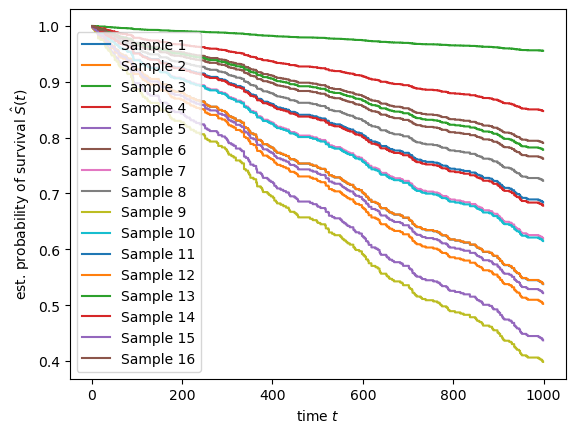

In [27]:
import matplotlib.pyplot as plt

pred_surv = estimator.predict_survival_function(X.loc[:15])
time_points = np.arange(1, 1000)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points), where="post",
             label="Sample %d" % (i + 1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")